In [9]:
# Install required packages
print("Installing required packages...")
!pip install -q diffusers transformers accelerate safetensors gradio pillow torch torchvision controlnet_aux

Installing required packages...




**Stable Diffusion Text-to-Image**



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

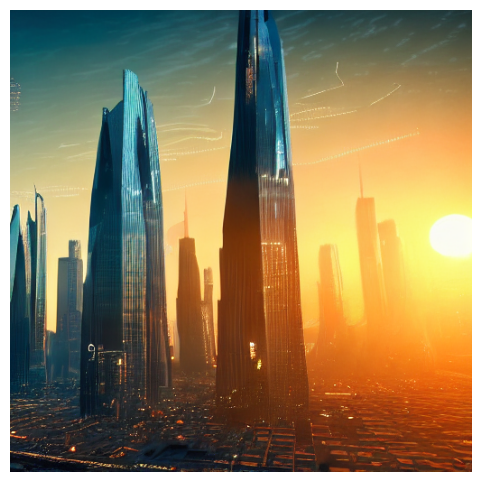

In [4]:

from diffusers import StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Detect device properly
# ------------------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32

# ------------------------------------------------------------
# 2. Load the model
# ------------------------------------------------------------
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=dtype
)

pipe = pipe.to(device)

# ------------------------------------------------------------
# 3. Define the Prompt
# ------------------------------------------------------------
prompt = "a futuristic city skyline at sunset, ultra-detailed, cinematic lighting, 4k"

# ------------------------------------------------------------
# 4. Generate the Image
# ------------------------------------------------------------
result = pipe(
    prompt=prompt,
    guidance_scale=7.5,
    height=512,
    width=512
)

# ------------------------------------------------------------
# 5. Save & Display
# ------------------------------------------------------------
image = result.images[0]
image.save("generated_city.png")

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.show()


**Sketches to Life with Generative AI**

In [ ]:
# Step 2: Import libraries
import gradio as gr
import torch
from PIL import Image, ImageOps
import numpy as np
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from controlnet_aux import HEDdetector
import io

print("Libraries imported successfully!")

# Step 3: Setup device and load models
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load ControlNet model for sketch/edge detection
print("Loading ControlNet model... (this may take a few minutes)")
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_scribble",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
)

# Load Stable Diffusion pipeline with ControlNet
print("Loading Stable Diffusion pipeline...")
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    safety_checker=None
)
pipe = pipe.to(device)

# Use faster scheduler
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Enable memory optimizations
if device == "cuda":
    pipe.enable_model_cpu_offload()
    pipe.enable_xformers_memory_efficient_attention()

print("Models loaded successfully!")

# Step 4: Helper functions
def preprocess_sketch(sketch_image):
    """Convert sketch to the right format for ControlNet"""
    # Convert to PIL Image if needed
    if isinstance(sketch_image, np.ndarray):
        sketch_image = Image.fromarray(sketch_image)

    # Convert to RGB
    sketch_image = sketch_image.convert("RGB")

    # Resize to 512x512 (standard SD size)
    sketch_image = sketch_image.resize((512, 512))

    # Invert if needed (white background, black lines)
    sketch_array = np.array(sketch_image)
    if sketch_array.mean() > 127:  # Light background
        sketch_image = ImageOps.invert(sketch_image)

    return sketch_image

def enhance_prompt_with_ai(base_prompt, sketch_type="general"):
    """Enhance the prompt for better photorealistic results"""
    if not base_prompt:
        base_prompt = "a detailed object"

    enhancement = (
        f"{base_prompt}, photorealistic, highly detailed, professional photography, "
        f"8k uhd, sharp focus, natural lighting, realistic textures, high quality, "
        f"masterpiece, best quality"
    )
    return enhancement

def generate_image(sketch, prompt, negative_prompt, num_steps, guidance_scale):
    """Generate realistic image from sketch"""
    try:
        # Preprocess the sketch
        control_image = preprocess_sketch(sketch)

        # Enhance the prompt
        enhanced_prompt = enhance_prompt_with_ai(prompt)

        # Default negative prompt if not provided
        if not negative_prompt:
            negative_prompt = (
                "blurry, bad quality, distorted, deformed, ugly, "
                "low resolution, cartoon, anime, drawing, sketch"
            )

        # Generate the image
        print(f"Generating image with prompt: {enhanced_prompt}")

        output = pipe(
            prompt=enhanced_prompt,
            negative_prompt=negative_prompt,
            image=control_image,
            num_inference_steps=num_steps,
            guidance_scale=guidance_scale,
            controlnet_conditioning_scale=0.8,
        )

        generated_image = output.images[0]

        return generated_image, enhanced_prompt

    except Exception as e:
        print(f"Error generating image: {str(e)}")
        return None, f"Error: {str(e)}"

# Step 5: Create Gradio Interface
def process_sketch(sketch_draw, sketch_upload, prompt, negative_prompt, num_steps, guidance_scale):
    """Main processing function for Gradio"""
    # Use uploaded image if available, otherwise use drawn sketch
    sketch = sketch_upload if sketch_upload is not None else sketch_draw

    if sketch is None:
        return None, "Please draw a sketch or upload an image first!"

    generated_img, enhanced_prompt = generate_image(
        sketch, prompt, negative_prompt, num_steps, guidance_scale
    )

    if generated_img:
        info = f"Enhanced Prompt Used:\n{enhanced_prompt}"
        return generated_img, info
    else:
        return None, enhanced_prompt  # Error message

# Create the Gradio interface
with gr.Blocks(title="Sketch-to-Realistic Image Generator") as demo:
    gr.Markdown("""
    # Sketch-to-Photorealistic Image Generator
    Draw a sketch or upload an image, add a description, and generate stunning realistic images!

    **Examples:** Try sketching a cat, building, car, person, or any object you want to see come to life!
    """)

    with gr.Row():
        with gr.Column():
            gr.Markdown("### Your Sketch")

            with gr.Tabs():
                with gr.Tab("Draw"):
                    sketch_input = gr.Sketchpad(
                        label="Draw your sketch here",
                        type="pil",
                        height=512,
                        width=512,
                        brush=gr.Brush(colors=["#000000"], default_size=3)
                    )

                with gr.Tab("Upload"):
                    upload_input = gr.Image(
                        label="Upload a sketch image",
                        type="pil",
                        height=512,
                        sources=["upload"]
                    )

            prompt_input = gr.Textbox(
                label="Description (what you want to generate)",
                placeholder="e.g., a realistic tabby cat, futuristic building, modern sports car...",
                lines=3
            )

            with gr.Accordion("Advanced Settings", open=False):
                negative_prompt_input = gr.Textbox(
                    label="Negative Prompt (what to avoid)",
                    placeholder="Leave empty for default",
                    lines=2
                )

                num_steps_slider = gr.Slider(
                    minimum=10,
                    maximum=50,
                    value=20,
                    step=1,
                    label="Number of Steps (more = better quality but slower)"
                )

                guidance_scale_slider = gr.Slider(
                    minimum=1.0,
                    maximum=15.0,
                    value=7.5,
                    step=0.5,
                    label="Guidance Scale (how closely to follow prompt)"
                )

            generate_btn = gr.Button("Generate Realistic Image", variant="primary", size="lg")

        with gr.Column():
            gr.Markdown("### Generated Result")
            output_image = gr.Image(
                label="Your Photorealistic Image",
                type="pil",
                height=512,
                width=512
            )

            output_info = gr.Textbox(
                label="Generation Info",
                lines=4,
                interactive=False
            )

    # Examples
    gr.Markdown("###  Tips for Best Results:")
    gr.Markdown("""
    - Draw clear, simple sketches with defined edges
    - Be specific in your description (mention colors, materials, style)
    - For realistic results, include words like "photorealistic", "detailed", "natural lighting"
    - Upload reference sketches for better structure guidance
    - Experiment with different guidance scales (7-9 works well for most cases)
    """)

    # Connect the button to the processing function
    generate_btn.click(
        fn=process_sketch,
        inputs=[sketch_input, upload_input, prompt_input, negative_prompt_input, num_steps_slider, guidance_scale_slider],
        outputs=[output_image, output_info]
    )

# Step 6: Launch the interface
print("\n" + "="*50)
print(" Launching Gradio Interface...")
print("="*50 + "\n")

demo.launch(share=True, debug=True)

Libraries imported successfully!
Using device: cpu
Loading ControlNet model... (this may take a few minutes)
Loading Stable Diffusion pipeline...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Models loaded successfully!

🚀 Launching Gradio Interface...

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://959dc917e785286226.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Generating image with prompt: i would like to generate the real image of a fish, photorealistic, highly detailed, professional photography, 8k uhd, sharp focus, natural lighting, realistic textures, high quality, masterpiece, best quality


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image with prompt: A fish, photorealistic, highly detailed, professional photography, 8k uhd, sharp focus, natural lighting, realistic textures, high quality, masterpiece, best quality


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image with prompt: draw me a fish plz, photorealistic, highly detailed, professional photography, 8k uhd, sharp focus, natural lighting, realistic textures, high quality, masterpiece, best quality


  0%|          | 0/20 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://959dc917e785286226.gradio.live
